# **Setup**

In [1]:
# !tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
import torch
print(torch.cuda.is_available())
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvcc -V

True
Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
# 표준 라이브러리
import os
import pickle
from glob import glob
from functools import partial
import gc

# 데이터 처리 및 시각화 관련 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 머신러닝, 데이터 전처리 및 증강 관련 라이브러리
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
from tqdm import tqdm

# TensorFlow 및 Keras 관련 라이브러리
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal

from keras.backend import clear_session
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# **Load data**

In [3]:
# 주어진 감정 딕셔너리는 각 감정 레이블에 해당하는 숫자를 나타냅니다.
emotions = {
    '0': 'angry',          # 0: 화남
    '1': 'embarrassed',    # 1: 당황
    '2': 'happy',          # 2: 행복
    '3': 'sad',            # 3: 슬픔
    '4': 'neutral'         # 4: 중립
}

# 새로운 딕셔너리 emo를 생성하여 감정 딕셔너리의 키와 값을 반대로 뒤집습니다.
emo = {
    value: key        # 감정 레이블을 키로 사용하고 해당하는 숫자를 값으로 사용합니다.
    for key, value in emotions.items()  # 감정 딕셔너리의 각 항목을 반복하면서 처리합니다.
}

# 생성된 emo 딕셔너리를 출력합니다.
print(emo)

# 변수 num_classes는 감정 클래스의 수를 저장하며, 이는 감정 딕셔너리의 항목 수와 동일합니다.
num_classes = len(emotions)


{'angry': '0', 'embarrassed': '1', 'happy': '2', 'sad': '3', 'neutral': '4'}


In [4]:
curr_dir = os.getcwd()
join_with_curr = partial(os.path.join, curr_dir)

def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f'create : {path}')
        return path
    else:
        print(f"{path} already exists.")
        return path

## **데이터 준비**

감정 분석을 위한 이미지 데이터셋을 준비하는 과정입니다.

---
### **데이터 로딩 함수 (load_data) 정의**
CSV 파일로부터 데이터를 로드하고, 이미지와 레이블을 NumPy 배열로 변환하는 함수를 정의합니다.  
try-except 블록을 사용하여 파일이 존재하지 않는 경우 오류 메시지를 출력합니다.

### **데이터 존재 여부 검사 함수 (exist_check) 정의**

주어진 데이터셋의 각 이미지 파일이 실제로 존재하는지 확인합니다.  
파일이 존재하지 않는 경우 해당 파일에 대한 오류 메시지를 출력하고, 존재하는 경우 새로운 CSV 파일을 생성합니다.

### **CSV 파일 병합 함수 (merge_csv_vertical) 정의**
주어진 디렉토리에 있는 모든 CSV 파일들을 병합하여 하나의 파일로 만드는 함수입니다.  
이미 병합된 파일이 존재하는 경우, 함수는 추가 작업 없이 종료됩니다.

In [5]:
def load_data(data_file):
    data_file = pd.read_csv(data_file) # pandas를 이용하여 CSV 파일을 읽습니다.
    x_data = [] # 이미지 배열을 저장할 리스트입니다
    y_data = [] # 감정 레이블을 저장할 리스트입니다.
    
    for i in range(len(data_file)):
        try:
            img = Image.open(data_file.iloc[i]['path'])   # PIL을 사용하여 이미지를 엽니다.
            label = emo[data_file.iloc[i]['label']]   # emo 사전을 사용하여 감정 레이블을 얻습니다.
            img_array = np.array(img)  # 이미지를 넘파이 배열로 변환합니다.
        except FileNotFoundError:
            print(f"{img} doesn't exist")
        else:
            x_data.append(img_array)  # 이미지 배열을 x_data에 추가합니다.
            y_data.append(label)   # 감정 레이블을 y_data에 추가합니다.
    
    x_data = np.array(x_data)  # 이미지 배열 리스트를 넘파이 배열로 변환합니다.
    y_data = np.array(y_data)  # 감정 레이블 리스트를 넘파이 배열로 변환합니다.
    print('Data loaded.')
    return x_data, y_data

def exist_check(dataset,csv_path_name):
    # 데이터 로딩을 시작한다는 메시지를 출력합니다.
    print('Loading data ...')
    db = []  # 이미지 경로-레이블 쌍을 저장할 리스트입니다.
    # 데이터셋의 각 행에 대해 반복합니다.
    for i in range(len(dataset)):
        try:
            # 이미지 경로를 얻습니다.
            path = dataset.iloc[i]['path']
            # 감정 레이블을 얻습니다.
            label = dataset.iloc[i]['label']
            # PIL을 사용하여 이미지를 엽니다.
            img = Image.open(path)
        except FileNotFoundError:
            # 파일을 찾을 수 없는 경우 오류 메시지를 출력합니다.
            print(f"{path} doesn't exist.")
        else:
            # 경로-레이블 쌍을 리스트에 추가합니다.
            db.append({'path': path, 'label': label})
    # 새로운 CSV 데이터셋 파일을 생성합니다.
    pd.DataFrame(db).to_csv(csv_path_name, index=False)
    print('exist check finished.')
    
def merge_csv_vertical(directory):
    # 병합된 파일의 경로를 설정합니다.
    merged_file = os.path.join(directory,'merged.csv')
    # 이미 병합된 파일이 존재하는 경우, 함수를 종료합니다.
    if os.path.exists(merged_file):
        print("merged_file_exists!!")
        return
    # 디렉토리에서 CSV 파일들을 찾습니다.
    files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    all_data = []
    # 각 파일에 대해 데이터를 읽고 리스트에 추가합니다.
    for file in files:
        file_path = os.path.join(directory, file)
        data = pd.read_csv(file_path)
        all_data.append(data)
    # 모든 데이터를 병합합니다.
    merged_data = pd.concat(all_data, ignore_index=True)  
    # 병합된 데이터를 CSV 파일로 저장합니다.
    merged_data.to_csv(merged_file,index = False)

### **각 감정에 대한 데이터셋 처리**

emo 딕셔너리를 사용하여 각 감정 레이블에 해당하는 훈련 및 검증 데이터셋의 CSV 파일 경로를 구성합니다.  
exist_check 함수를 호출하여 각 CSV 파일의 이미지 파일 존재 여부를 확인하고, 필요한 경우 새로운 CSV 파일을 생성합니다.

In [6]:
for e in emo:
    korean_data_csv = join_with_curr('dataset','train','csvs',e+'.csv')
    data_file = pd.read_csv(korean_data_csv)  
    exist_check(data_file,korean_data_csv) 
merge_csv_vertical(join_with_curr('dataset','train','csvs'))

Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
Loading data ...
exist check finished.
merged_file_exists!!


### ***데이터셋 병합 및 로드***

merge_csv_vertical 함수를 사용하여 훈련 및 검증 데이터셋의 모든 CSV 파일을 병합합니다.  
병합된 훈련 및 검증 데이터셋 CSV 파일의 경로를 설정합니다.  
load_data 함수를 호출하여 훈련 및 검증 이미지와 레이블을 로드합니다.

In [7]:
data_file = join_with_curr('dataset','train','csvs','merged.csv')


images, labels = load_data(data_file)


n_samples = labels.shape[0]


print('Total samples:', n_samples)       
print('images shape:', images.shape)     
print('labels shape:', labels.shape)    


Data loaded.
Total samples: 291383
images shape: (291383, 224, 224)
labels shape: (291383,)


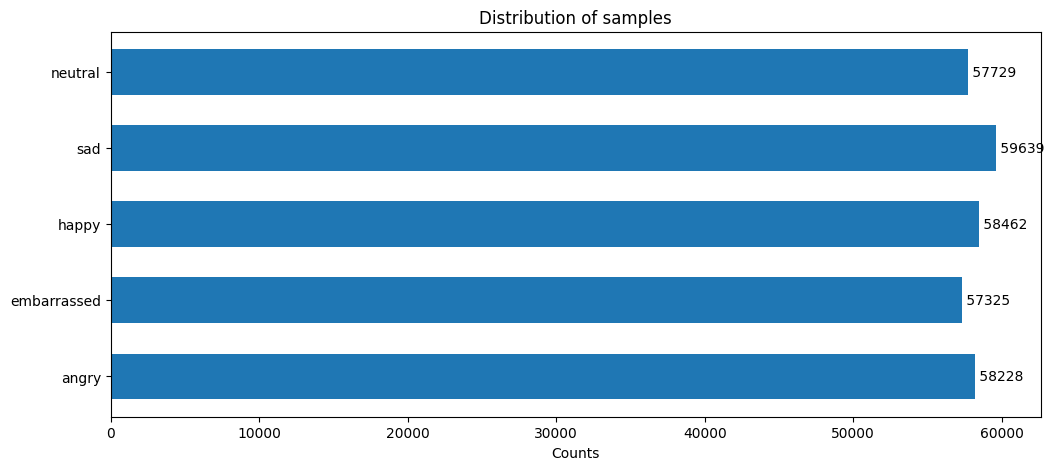

In [8]:
def plot_sample_distribution(labels):
    """
    Plots the distribution of samples for each emotion class.

    Args:
        labels (numpy.ndarray): An array containing emotion labels for each sample.

    Returns:
        None
    """
    classes, cnts = np.unique(labels, return_counts=True)  # Calculate unique labels and their counts.
    plt.figure(figsize=(12, 5))  # Create a new figure with a specific size.
    plt.barh(list(emotions.values()), cnts, height=0.6)  # Create a horizontal bar plot.
    for i, v in enumerate(cnts):
        plt.text(v, i, ' ' + str(v), va='center')  # Display the count value on each bar.
    plt.xlabel('Counts')  # Set the label for the x-axis.
    plt.title("Distribution of samples")  # Set the title of the plot.

# Call the function to plot the sample distribution based on the 'labels' array.
plot_sample_distribution(labels)

In [9]:
def show_images(images, labels, col=5):
    """
    Displays a grid of images along with their corresponding emotion labels.

    Args:
        images (numpy.ndarray): An array containing image data.
        labels (numpy.ndarray): An array containing emotion labels for each image.
        col (int, optional): Number of columns in the grid. Defaults to 5.

    Returns:
        None
    """
    n = images.shape[0]  # Get the total number of images.
    row = int(np.ceil(n / col))  # Calculate the number of rows based on the given number of columns.
    fig = plt.figure(figsize=(2 * col, 2 * row))  # Create a figure for displaying the grid.

    for i in range(n):
        fig.add_subplot(row, col, i + 1)  # Add a subplot for each image.
        plt.imshow(images[i], cmap='gray')  # Display the image using a grayscale colormap.
        plt.title(emotions[labels[i]])  # Set the title of the subplot as the corresponding emotion label.
        plt.xticks([]), plt.yticks([])  # Remove x and y axis ticks.

    plt.show()  # Display the grid of images.



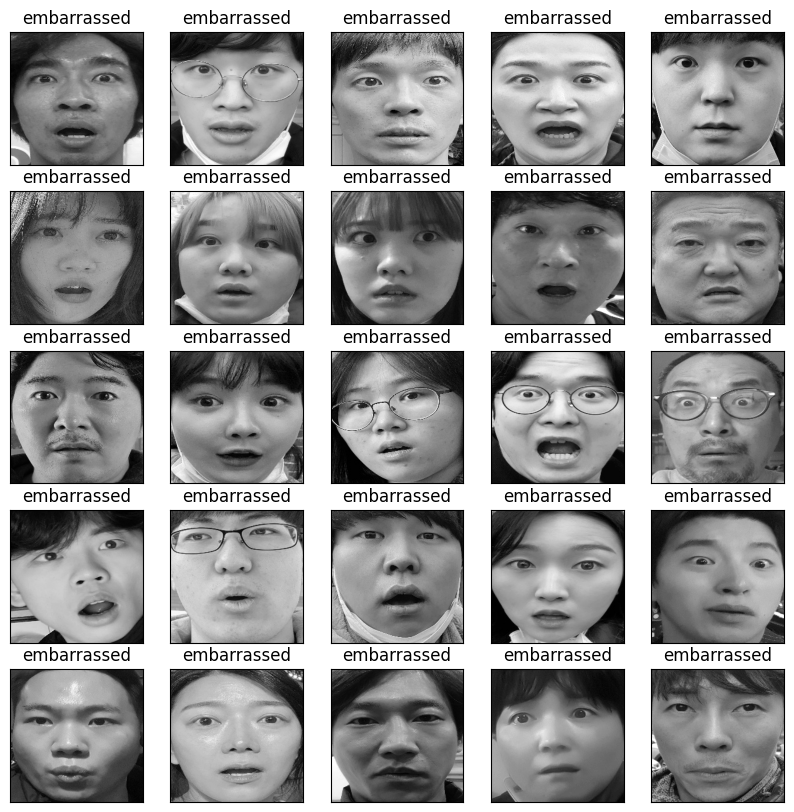

In [10]:
def show_one_emotion(images, labels, id, start=0, num=25):
    """
    Displays a grid of images belonging to a specific emotion label.

    Args:
        images (numpy.ndarray): An array containing image data.
        labels (numpy.ndarray): An array containing emotion labels for each image.
        id (str or int): The emotion label to display images for.
        start (int, optional): Index to start selecting images from. Defaults to 0.
        num (int, optional): Number of images to display. Defaults to 25.

    Returns:
        None
    """
    image_x = images[labels == id]  # Filter images based on the given emotion label.
    label_x = labels[labels == id]  # Filter labels based on the given emotion label.
    
    # Call the show_images function to display the selected images with the filtered labels.
    show_images(image_x[start:start + num], label_x[start:start + num])

# Call the function to display images for a specific emotion label.
show_one_emotion(images, labels, id='1')


# **Split dataset**

In [11]:
image_train, image_val, label_train, label_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print('Training samples:', label_train.shape[0])
print('Validation samples:', label_val.shape[0])

Training samples: 233106
Validation samples: 58277


# **Upsamling training data**

In [12]:
def upsampling(x, y, strategy):
    (n, w, h) = x.shape  
    sm = SMOTE(sampling_strategy=strategy, random_state=42)  #
    x_flat = x.reshape((n, -1))  
    x_up, y_up = sm.fit_resample(x_flat, y) 
    n_up = x_up.shape[0]  
    x_up = x_up.reshape((n_up, w, h)) 

    return x_up, y_up  

In [13]:
collections.Counter(label_train)

Counter({'3': 47653, '2': 46823, '0': 46596, '4': 46167, '1': 45867})

In [14]:
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [15]:
with open('./pickle_jar/image_train_up.pickle','wb') as fw:
    pickle.dump(image_train_up,fw, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_jar/label_train_up.pickle','wb') as fw:
    pickle.dump(label_train_up,fw, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_jar/image_val.pickle','wb') as fw:
    pickle.dump(image_val,fw,  protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_jar/labal_val.pickle','wb') as fw:
    pickle.dump(label_val,fw,  protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
del image_train_up, label_train_up, image_val, label_val

In [17]:
gc.collect()

52626

In [18]:
with open('./pickle_jar/image_train_up.pickle','rb') as fr:
    image_train_up = pickle.load(fr)
with open('./pickle_jar/label_train_up.pickle','rb') as fr:
    label_train_up = pickle.load(fr)
with open('./pickle_jar/image_val.pickle','rb') as fr:
    image_val = pickle.load(fr)
with open('./pickle_jar/labal_val.pickle','rb') as fr:
    label_val = pickle.load(fr)

In [19]:
collections.Counter(label_train_up)

Counter({'1': 47653, '0': 47653, '3': 47653, '2': 47653, '4': 47653})

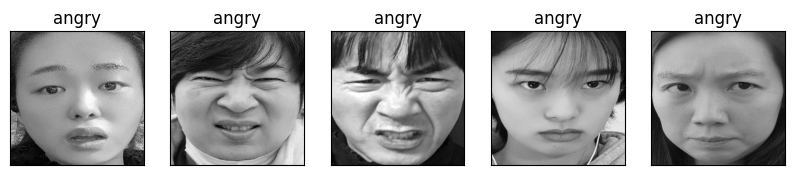

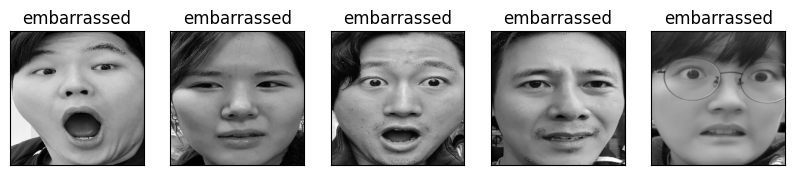

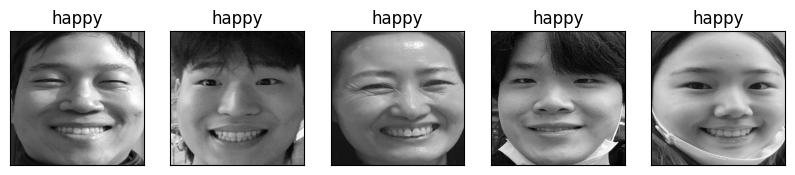

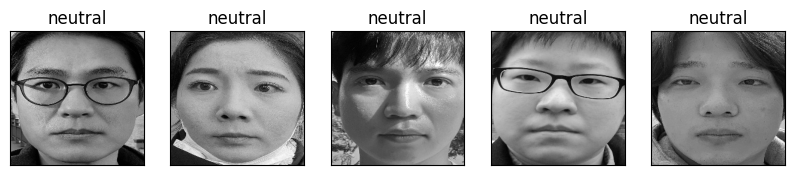

In [20]:
for i in range(num_classes):
    if i == 3:  # Skip class 3 (neutral) using the 'continue' statement.
        continue
    show_one_emotion(image_train_up, label_train_up, id=f'{i}', start=4000, num=5)

# **Utils**

In [21]:
def one_hot_encoding(labels, num_classes):
    return tf.keras.utils.to_categorical(labels, num_classes)


In [22]:
def reshape_images(images, channel=1, resize=None):
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)    
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)
    if resize is not None:
        x = tf.image.resize(x, resize) 
    return x

In [23]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y


In [24]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1, 2, n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model ' + name)
        plt.legend()

    plt.show()

In [25]:
def evaluate_class(model, x_test, y_test):
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    
    for i in range(num_classes):
        x = x_test[labels == i]
        y = y_test[labels == i]
        loss, acc = model.evaluate(x, y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[f'{i}'], acc))
    
    print('-'*23)
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))


# **Model**

In [26]:
def model_checkpoint_cb(file_path):
    return ModelCheckpoint(
        file_path, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=True, verbose=1)

In [27]:
# Data Preprocessing
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)

In [28]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

# Batch Size
batch_size = 8

# Creating Data Generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

# Setting Training Parameters
steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape

In [29]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, dropout_1, dropout_2, checkpoint_path, lr=1e-3):
        super().__init__()

        self.add(Rescaling(1./255, input_shape=input_shape))
        
        # Convolutional Blocks
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_1))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_2))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_1))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(dropout_2))
        
        # Fully Connected Layers
        self.add(Flatten())
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(dropout_1))
        self.add(Dense(256, activation='relu'))

        # Output Layer
        self.add(Dense(num_classes, activation='softmax'))

        # Compile the Model
        self.compile(optimizer=Adam(learning_rate=lr),
                     loss=categorical_crossentropy,
                     metrics=['accuracy'])

        # Save Checkpoint Path
        self.checkpoint_path = checkpoint_path


In [31]:
# VGGNet 모델 인스턴스를 생성합니다.
dropout_1 = 0.1  # 첫 번째 드롭아웃 비율
dropout_2 = 0.1  # 두 번째 드롭아웃 비율
model = VGGNet(input_shape, num_classes,dropout_1,dropout_2 ,join_with_curr('models','vggnet_korean_trained.h5'),lr = 1e-4)


pretrained_model_path = join_with_curr('models','vggnet_fer_trained.h5')

model.load_weights(pretrained_model_path)

model.summary()

Model: "vgg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0   

In [32]:
# 훈련할 에포크 수를 설정합니다.
epochs = 500
# 콜백을 정의합니다.
cp = model_checkpoint_cb(model.checkpoint_path)  # 모델 체크포인트 저장
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-10)  # 학습률 조정
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)  # 조기 종료

# 모델 훈련을 시작합니다.
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[lr, es, cp])  # 정의된 콜백을 훈련에 적용


Epoch 1/500
29782/29783 [============================>.] - ETA: 0s - loss: 0.5356 - accuracy: 0.8154
Epoch 1: val_accuracy improved from -inf to 0.87139, saving model to C:\Users\royal\Desktop\ML\project\models\vggnet_korean_trained.h5
29783/29783 [==============================] - 945s 32ms/step - loss: 0.5357 - accuracy: 0.8154 - val_loss: 0.3909 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 2/500
29782/29783 [============================>.] - ETA: 0s - loss: 0.4388 - accuracy: 0.8514
Epoch 2: val_accuracy did not improve from 0.87139
29783/29783 [==============================] - 941s 32ms/step - loss: 0.4388 - accuracy: 0.8514 - val_loss: 0.4085 - val_accuracy: 0.8661 - lr: 1.0000e-04
Epoch 3/500
29783/29783 [==============================] - ETA: 0s - loss: 0.4016 - accuracy: 0.8651
Epoch 3: val_accuracy improved from 0.87139 to 0.88814, saving model to C:\Users\royal\Desktop\ML\project\models\vggnet_korean_trained.h5
29783/29783 [==============================] - 943s 32ms/step -

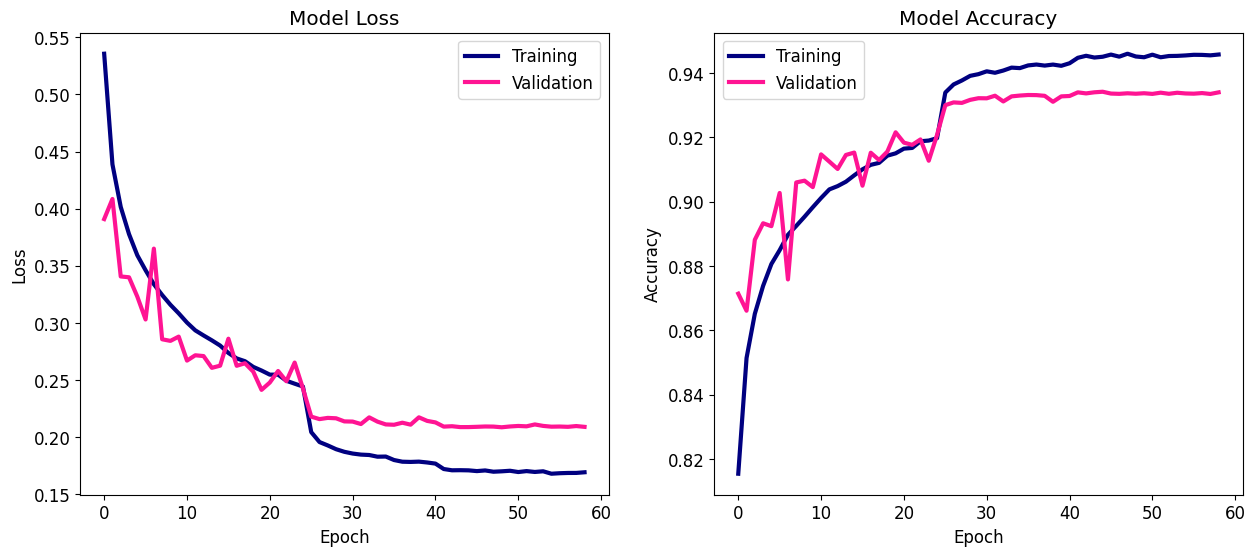

In [33]:
# Plot training metrics
plot_metrics(history)

In [ ]:
del image_train_up, label_train_up, image_val, label_val,x_train, y_train,x_val, y_val
gc.collect()

In [49]:
# emo 사전에 있는 각 감정 레이블에 대해 반복합니다.
for e in emo:
    print(e)
    korean_test_csv = join_with_curr('dataset', 'test', 'csvs', e + '.csv')
    data_file = pd.read_csv(korean_test_csv)  # CSV 파일을 pandas DataFrame으로 로드합니다.
    print(data_file[:5])
    exist_check(data_file, korean_test_csv)  # 이미지 존재 여부를 확인하고 새로운 데이터셋 CSV 파일을 생성합니다.
# 모든 감정 레이블에 대한 CSV 파일을 병합합니다.
korean_test_csv = join_with_curr('dataset', 'test', 'csvs')
merge_csv_vertical(korean_test_csv)

angry
                                                path  label
0  ./dataset/test/angry/00varoy0jfvqrn2hrxxqtikwv...  angry
1  ./dataset/test/angry/01dbm4duono2tgvo3cbnjetcs...  angry
2  ./dataset/test/angry/02ep7tbnfrstjwulsntntdeys...  angry
3  ./dataset/test/angry/02teqi8isrnvly0bhym2qrcym...  angry
4  ./dataset/test/angry/03obmmx0cghukadf36wtddmtd...  angry
Loading data ...
exist check finished.
embarrassed
                                                path        label
0  ./dataset/test/embarrassed/00v7jnyq4rxsyleebxt...  embarrassed
1  ./dataset/test/embarrassed/01dlhtabbbgkntvget0...  embarrassed
2  ./dataset/test/embarrassed/01lgflaxqlnuttmlg4v...  embarrassed
3  ./dataset/test/embarrassed/02jlpjd2ngs2yar0gra...  embarrassed
4  ./dataset/test/embarrassed/04kiitapjpb7qkgf7ly...  embarrassed
Loading data ...
exist check finished.
happy
                                                path  label
0  ./dataset/test/happy/00gdhjcvi8lb0ifnwubnvohre...  happy
1  ./dataset/test/happ

In [50]:
def shuffling(image, label,random_state = 42):
    # 난수 생성기의 시드 설정
    np.random.seed(random_state)
    indices = np.arange(len(image))
    # 인덱스에 따라 X와 y 데이터 섞기
    np.random.shuffle(indices)
    image_res = image[indices]
    label_res = label[indices]
    return image_res, label_res

Data loaded.
Korean test samples: 36597
Korean test images shape: (36597, 224, 224)
Korean test labels shape: (36597,)


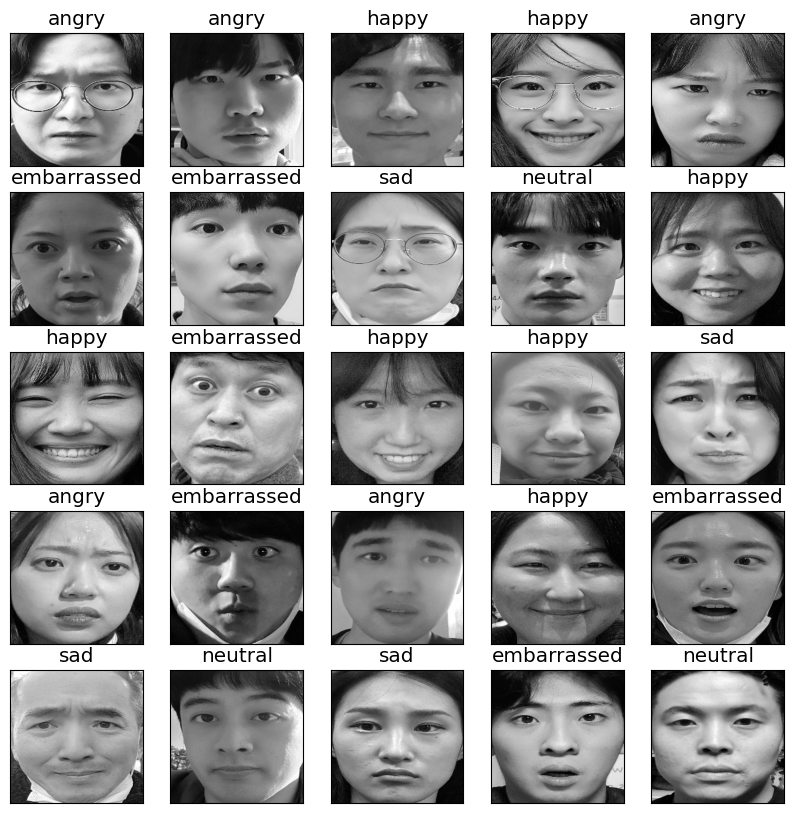

In [51]:
# 병합된 CSV 파일의 경로를 설정합니다.
korean_test_csv_merged = os.path.join(korean_test_csv, 'merged.csv')
# 데이터를 로드합니다.
korean_test_images, korean_test_labels = load_data(korean_test_csv_merged)
# 데이터셋의 샘플 수를 계산합니다.
korean_test_n_samples = korean_test_labels.shape[0]

# 데이터셋 정보를 출력합니다.
print('Korean test samples:', korean_test_n_samples)
print('Korean test images shape:', korean_test_images.shape)
print('Korean test labels shape:', korean_test_labels.shape)

korean_image_test, korean_label_test = shuffling(korean_test_images, korean_test_labels, random_state=42) # 데이터셋을 셔플링합니다.
# 처음 25개의 이미지를 표시합니다.
show_images(korean_image_test[:25], korean_label_test[:25])

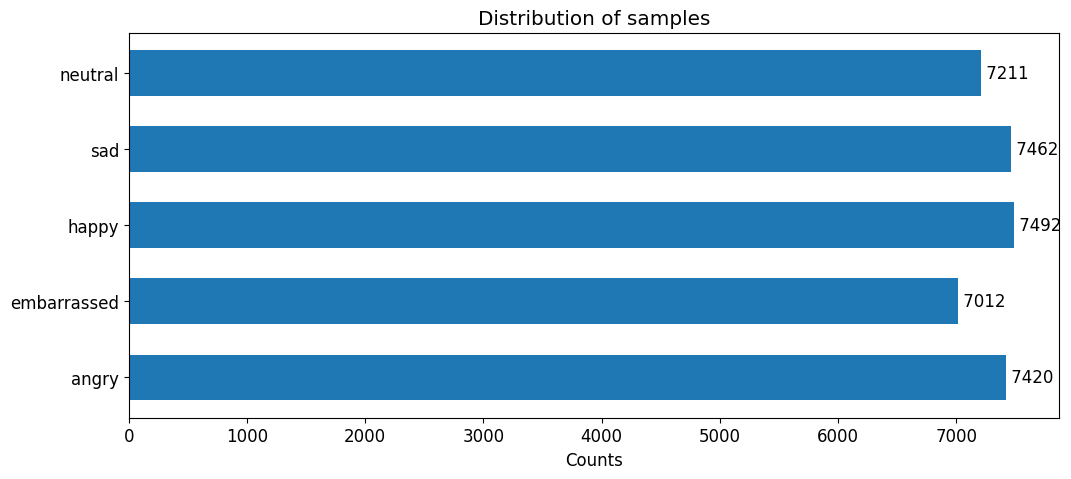

In [52]:
# 샘플 분포를 시각화합니다.
plot_sample_distribution(korean_label_test)

In [53]:
korean_image_test, korean_label_test = pre_processing(korean_image_test, korean_label_test, num_classes)

In [54]:
# 최적의 모델 가중치를 체크포인트에서 로드합니다.
model.load_weights(model.checkpoint_path)
# 테스트 데이터에 대해 모델을 평가합니다.
evaluate_class(model,korean_image_test, korean_label_test)

Emotion        Accuracy
-----------------------
angry          89.7%
embarrassed    92.0%
happy          97.0%
sad            93.0%
neutral        94.6%
-----------------------
Overall        93.3%


In [55]:
# Save the trained model
model.save(model.checkpoint_path)